# Predicting House Prices in King County, Washington
## Multilinear Regression Model

## Alternative Hypothesis:
Proximity to Seattle and Bellevue are associated with an increase in price.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
from scipy.stats import zscore

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
from functions1 import std_describe, percent_null_df, obtain_data
from functions1 import idx_select_sort_set, remove_dupes, find_nulls
from functions1 import rm_outliers_by_zscore, corr_heat_map, draw_qqplot
from functions1 import reg_summary, get_residual, validate_reg_assumptions
from functions1 import locate_it, haversine, box_cox

## 1. Obtaining Data

In [2]:
data = obtain_data('https://raw.githubusercontent.com/xinegan88/Module-2-Project/master/kc_house_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## 2. Scrubbing Data

### i. Selecting, Sorting, and Setting the Index
Examining the first few rows of the dataframe, we can see that there is column called 'id.' We can assume that each house is given its own unique id number. However, since there is also a date column, we should check for duplicates in both 'id' and 'date' before we set the index to 'id.' In addition, it would be helpful to transform 'date' into a datetime object so we can use it to create other features later on.

### ii. Identifying Null Values
The columns 'view' and 'waterfront' contain very little data. In the 'waterfront' column, we can see that there are only 146 properties out of more than 21,000 properties that can be considered waterfront properties. From this perspective, it seems like an unlikely predictor. Similarly, in 'view', only a small number of properties have ever been viewed. Due to this reasons, we will drop these columns. In 'yr_renovated', nearly 93% of the data is null or 0.0. Due to this, it also seems like a poor choice of a predictor and should be dropped.

### iii. Changing Data Types
In the information above, 'sqft_basement' is described as an 'object' when it is clear that the data in the column should be numeric. First, we will check the values to make sure they are all numeric, then we will change the column to a numeric data type. For some reason, there are a bunch of question marks in this column. Since it is a few hundred rows, we don't want to completely eliminate them from the data set. We will set them to '0'.

In [3]:
#i. select, sort, and set the index, change the date to a datetime object
indices = ['id', 'date']
data = idx_select_sort_set(data, indices)

# ii. identifying null values and taking action
print(find_nulls(data))
data = data.drop(['view', 'waterfront', 'yr_renovated'], axis=1) 

# iii. changing data types
data['sqft_basement'] = data.sqft_basement.replace('?', '0')
data['sqft_basement'] = pd.to_numeric(data.sqft_basement, errors='coerce')
data['sqft_basement'] = data.sqft_basement.fillna('0')


                  Index Report                       
------------------------------------------------------
              Primary Index Set as:  id
            Secondary Index Set as:  date 


                Duplicate Report                  
------------------------------------------------------
            353  duplicates found in  id
            167  duplicates found in  date
           177 duplicates removed. 


              Null & Unique Values Report                  
               for Columns with Null Values                  
------------------------------------------------------
waterfront
-------------
Null values:  2345
Unique values:  3 

Value Counts
------------
0.0    18929
1.0      146
Name: waterfront, dtype: int64 

view
-------------
Null values:  63
Unique values:  6 

Value Counts
------------
0.0    19253
2.0      956
3.0      505
1.0      329
4.0      314
Name: view, dtype: int64 

yr_renovated
-------------
Null values:  3813
Unique values:  71 

Value Coun

## 3. Exploring Data

### i. Box Cox Transformation

The graphs below indicate that there is a left skew in quite a few columns.

One way to address this skew is by using a box cox transformation. The differences between smaller values will be expanded (because the slope of the logarithmic function is steeper when values are small) whereas the differences between larger values will be reduced (because of the very moderate slope of the log distribution for larger values). If you inflate differences on the left tail and reduce differences on the right side tail, the result will be a symmetrical normal distribution, and a variance that is now constant (whatever the mean). 

In [4]:
drop_cols = ['date', 'lat', 'long', 'zipcode', 'condition', 'floors'] # not necessary for histogram

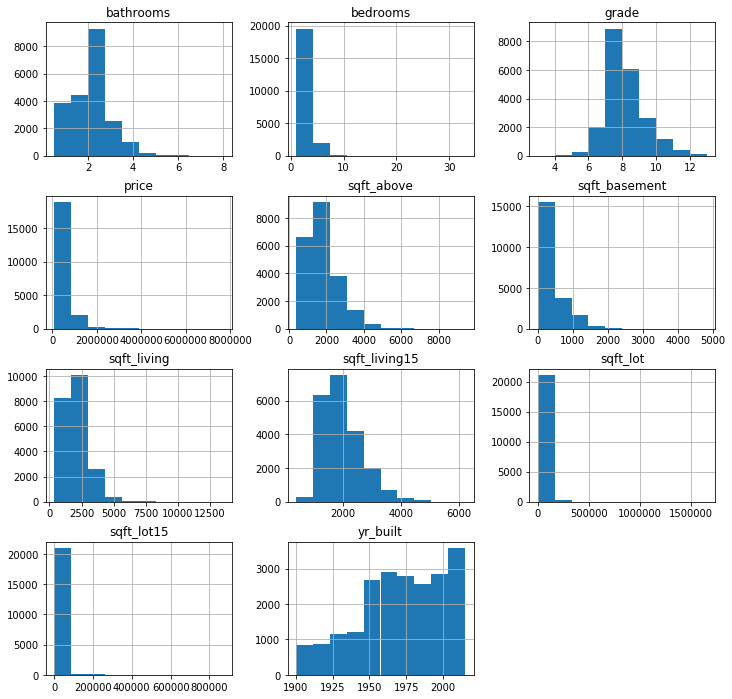

In [5]:
data.drop(drop_cols,axis=1).hist(figsize=(12,12));

In [6]:
skew_cols = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
data = box_cox(data, skew_cols)

There are 5 higest skewed numerical features to box cox transform


,Skew,New Skew
sqft_lot,13.055338,-0.106335
price,4.031647,-0.011012
sqft_basement,1.604050,0.482340
sqft_living,1.472599,-0.000239
sqft_above,1.444900,0.013747


None


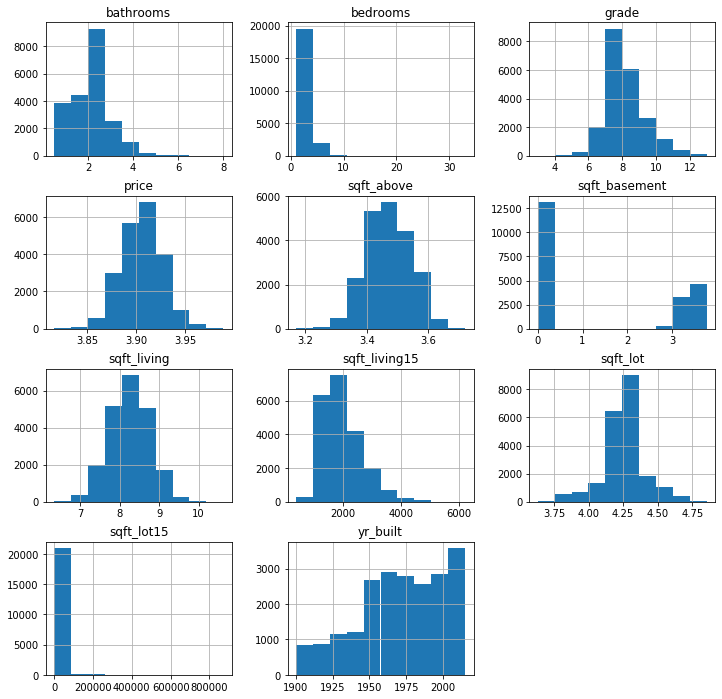

In [7]:
data.drop(drop_cols,axis=1).hist(figsize=(12,12));

### ii. Addressing Outliers by Z-Score
The columns 'price', 'bedrooms', and 'bathrooms' seem to have some outliers with exetreme values on the higher end. I want restrict the data to values that have a z-score with an absolute value of less than 3. This will enable the data to have some degree of variation, without allowing exetreme outliers to strongly influence the data.

In [8]:
std_describe(data.drop(drop_cols, axis=1)) 

                  Description with |3| STD Report                          
               price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count   21420.000000  21420.000000  21420.000000  21420.000000  21420.000000   
mean        3.905544      3.373950      2.118429      8.246773      4.254464   
std         0.020996      0.925405      0.768720      0.503684      0.153080   
min         3.815946      1.000000      0.500000      6.335170      3.632462   
25%         3.891526      3.000000      1.750000      7.904810      4.182056   
50%         3.905518      3.000000      2.250000      8.253697      4.258579   
75%         3.919610      4.000000      2.500000      8.591979      4.317116   
max         3.989139     33.000000      8.000000     10.627871      4.855050   
+3_std      3.968533      6.150163      4.424589      9.757826      4.713705   
-3_std      3.842555      0.597736     -0.187731      6.735719      3.795224   

               grade    sqft_above  sqft_ba

In [9]:
cols = ['price', 'bedrooms', 'bathrooms','sqft_living', 'grade']
data = rm_outliers_by_zscore(data, cols)


              Outlier Removal Report                  
         for columns:  ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'grade']
------------------------------------------------------

 price 
-------------
Number of Outliers Removed:  97
0.453 % of the total rows.


 bedrooms 
-------------
Number of Outliers Removed:  60
0.28 % of the total rows.


 bathrooms 
-------------
Number of Outliers Removed:  151
0.705 % of the total rows.


 sqft_living 
-------------
Number of Outliers Removed:  34
0.159 % of the total rows.


 grade 
-------------
Number of Outliers Removed:  70
0.327 % of the total rows.

------------------------------------------------------------
Total percentage of data removed:  1.92
Total rows of data removed:  412
New length of dataframe:  21008
------------------------------------------------------------


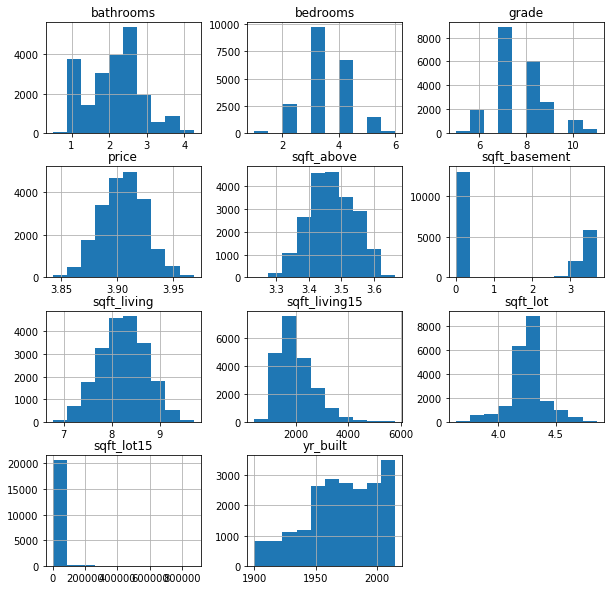

In [10]:
data.drop(drop_cols, axis=1).hist(figsize=(10,10));

### iii. Features

In [11]:
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

The following features were eliminated:

| Feature     | Reason for Elimination |
|:---------   | :-----------|    
| data | There are only two years represented in this data set. |
| floors | To limit complexity, size will captured by other features. |
| sqft_lot | This analysis is going to focus on living space as a secondary factor.|
| sqft_lot15 | Location and size will be addressed by other features. |
| sqft_living15 | Location and size will be addressed by other features. |
| sqft_above | This information is captured by square foot living.|
| sqft_basement | Homes with no basement are represented by zero, creating a severe left skew. Considering that sqft_living is the sum of sqft_basement, and sqft_above, assigning sqft_basement with a binary variable will retain the information while eliminatig a problematic column. |
| yr_built | Unneccessary to test our hypothesis. |

In [12]:
data['basement'] = data.sqft_basement.apply(lambda x: 1 if x > 0 else 0)

In [13]:
drop_cols = ['date', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
               'yr_built', 'sqft_living15', 'sqft_lot15', 'bathrooms', 
               'lat', 'long', 'grade']

In [14]:
t_data = data.copy()

### iv. Multicollinearity Check

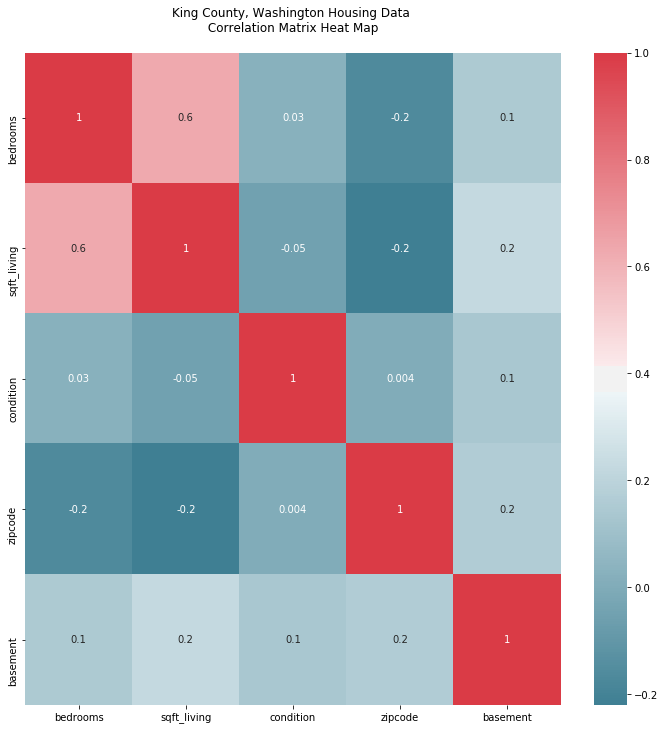

In [15]:
drop_cols.append('price')
corr_heat_map(t_data, drop_cols)
plt.title('King County, Washington Housing Data \n Correlation Matrix Heat Map \n');
drop_cols.remove('price')

## 4. Modeling and Interpreting the Data

In order to create a model that will examine the importance proximity to Seattle or Bellevue, we will identify the coordinates of Seattle and Bellevue, then create two new features that capture the distance between the coordinates in a given observation and Seattle/Bellevue.

In [16]:
x_data = t_data.copy()
x_data['long_lat'] = tuple(zip(x_data.long, x_data.lat))
47.6101, 122.2015
x_data['dist_to_seattle'] = x_data['long_lat'].apply(haversine, other=[47.6092, -122.3363])
x_data['dist_to_bellevue'] =x_data['long_lat'].apply(haversine, other=[47.6062,122.3321])

Next, we will dummy encode each zipcode, dropping the Seattle and Bellevue zipcodes.

In [17]:
zips = pd.get_dummies(x_data.zipcode)
x_data = pd.concat([x_data, zips], axis=1)
drop_cols.append('zipcode')
drop_cols.append('long_lat')

Finally, we will proceed with the following features:

In [18]:
x_data = x_data.drop(drop_cols, axis=1)
x_data.columns

Index([           'price',         'bedrooms',      'sqft_living',
              'condition',         'basement',  'dist_to_seattle',
       'dist_to_bellevue',              98001,              98002,
                    98003,              98004,              98005,
                    98006,              98007,              98008,
                    98010,              98011,              98014,
                    98019,              98022,              98023,
                    98024,              98027,              98028,
                    98029,              98030,              98031,
                    98032,              98033,              98034,
                    98038,              98039,              98040,
                    98042,              98045,              98052,
                    98053,              98055,              98056,
                    98058,              98059,              98065,
                    98070,              98072,              98

Retrieving OLS Summary...

const          6.944190
bedrooms      -0.001751
sqft_living    0.027153
condition      0.001542
basement      -0.002617
                 ...   
98177          0.097879
98178          0.085708
98188          0.082914
98198          0.083941
98199          0.110545
Length: 77, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     905.3
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:10:51   Log-Likelihood:                 49332.
No. Observations:               14705   AIC:                        -9.851e+04
Df Residuals:                   14629   BIC:                        -9.793e+04
Df Model:                          75             


Verifying Normality of Residuals...



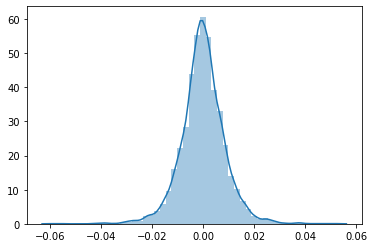

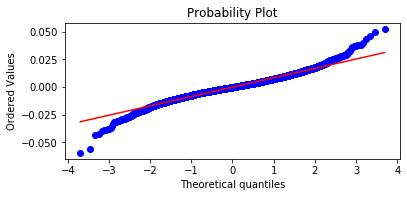

Mean of Residuals:  -5.995423709292644e-05

Displaying Regplot...



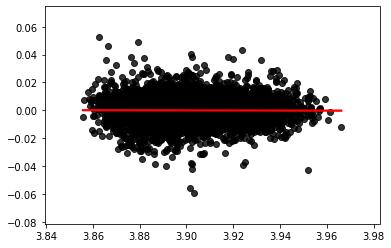

In [19]:
X = x_data.drop(['price'], axis=1)
y = x_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

### 5. Interpreting Data

#### R-Squared/Adjusted R-Squared
At .823/.822, the model can be considered reasonably accurate, and the predictors can be considered relevant.

#### Coefficients
It appears from the coefficients that distance to Seattle or Bellevue is a very important predictor of price. The further away a home is from Seattle or Bellevue, the lower the price seems to go.

Another good indicator seems to be squarefoot of living space.

All of the zipcodes appear to be in a similar range, 

#### T-Values/P-Values
The t-values all seem high enough, with the sqft_living t-value being particularly high in the positive direction. The t-values for the zip codes all seem to be in different, but all the values seem to fall between 6 and 10. Condition is confirmed as being a fairly strong positive influence, while basements and too many bedrooms seem to be a negative influence. The p-values are all very close to zero, so we can trust the p-values. We can reject the null-hypothesis that proximity to Seattle/Bellevue is the most important predictor. 

#### Satisfying the Assumptions of Linear Regression
The data appears to be normally distributed.    

Homoscedacity seems to be fairly neutral based on the scatterplot.


## Conclusions

#### 1. Start with location
Distance to Seattle/Bellevue is an important factor, and homes become more expensive as we move closer to either of these areas. Naturally, certain zipcodes seem to command the highest prices.

**Most Pricey Zipcodes, in Descending Order**

| Rank        | Zipcode     | City        | Notable Qualities                    |
|:---------   | :-----------| :-----------| :-----------                         | 
| 1           | 98039       | Medina      |  Waterfront zipcode outside Bellevue |
| 2           | 98040       | Mercer Island | Island between Seattle & Bellevue  |
| 3           | 98112       | Seattle/Madison Park | Waterfront neighnorhood in North East Seattle |
| 4           | 98102       | Seattle/East Lake/Capitol Hill | Waterfront neighborhood just West of Madison Park |
| 5           | 98119       | Seattle West Queen Anne/North Queen Anne | Waterfront neighnorhood in North West Seattle |
| 6           | 98109       | Seattle East Queen Anne/West Lake | Waterfront neighnorhood in North West Seattle, near Capitol Hill |
| 7           | 98122       | Seattle Central District | North east Seattle, below Madison Park |
| 8           | 98005       | Crossroads | Just east of Bellevue
| 9           | 98199       | Magnolia | North-West Peninsula of Seattle
| 10          | 98006       | Factoria | Just South of Bellevue

Some research on these zipcode support the assertion that proximity to Seattle and Bellevue is very important.

#### 2. Focus on size
Square footage of living space was also an important factor, and in certain zipcodes, a small increase square footage is leading to large increase in price.

#### 3. Pay Attention to Function
More bedrooms in a home can indicate less functional, smaller bedrooms if there is not a sufficient increase in square feet of living space. In addition, the presence of a basement indicates that total above ground living space could be as much as 50% of the entire living space. Having that square footage below ground can be less functional for home owners. Having more space above ground for functions that could be carried out in a basement like a laundry room, storage, or den, is more desirable above ground. I can also imagine that in a coastal city, a basement can be a huge liability. Above ground square footage is worth more, and the functionality of the home's layout is an important contributor.